In [1]:
# Sample code for analysis done in The Block Auction Infrastructure Race
# https://collective.flashbots.net/t/the-block-auction-infrastructure-race/4734/

# Author: Data Always - Flashbots
# Last Modified: March 13, 2025
# License: CC0

In [2]:
# Assumed directory structure to run this demo code
# | this notebook
# | mapping_pubkey_builder_name.csv (https://datasets.flashbots.net/)
# | /data
#   | /relayscan-websocket (from https://bidarchive.relayscan.io/index.html)
#       | 2024-06-03_top.csv.zip (or whatever time period you're interested in)
#       | 2024-06-04_top.csv.zip
#       | ...
#       | 2024-07-01_top.csv.zip
#       | ...


# This demo only uses relayscan's websocket datasets, but you can adapt it easily
# to use full bid data if you want. You just need to pseudo-recreate the websocket
# feed by sorting the bids and then removing any bid that isn't a new maximum

#df.sort_values(by=['slot', 'slot_t_ms'])
#df['cummax'] = df.groupby('slot')['value_eth'].cummax()
#tmp = df[df['cummax'] == df['value_eth']]


In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
import pandas as pd
from pathlib import Path

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [4]:
# Define colors
OFF_BLACK = '#05050e'
OFF_WHITE = '#f3f1ec'
SPINE_COLOR = [0.25, 0.25, 0.35]
GRID_COLOR = [0.75] * 3
TICK_COLOR = [0.3] * 3

def set_plt_defaults(figsize=(12, 7), left=0.10, top=0.88, right=0.95, bottom=0.13, grid_on=True):
    """Set default matplotlib styling."""
    plt.rcParams.update({
        'figure.figsize': figsize,
        'figure.subplot.left': left,
        'figure.subplot.top': top,
        'figure.subplot.right': right,
        'figure.subplot.bottom': bottom,
        'text.color': OFF_WHITE,
        'axes.labelcolor': OFF_WHITE,
        'xtick.color': OFF_WHITE,
        'ytick.color': OFF_WHITE,
    })
    
    fig, ax = plt.subplots()
    ax.yaxis.set_ticks_position('none')  # Remove y-axis tick marks
    
    if grid_on:
        ax.grid(color=GRID_COLOR, linestyle='-', linewidth=0.85, alpha=0.15, zorder=0)
        ax.xaxis.grid() # Only display horizontal axis
    
    ax.xaxis.set_tick_params(length=5, color=TICK_COLOR)
    ax.yaxis.set_tick_params(length=0, color=TICK_COLOR)
    
    fig.set_facecolor(OFF_BLACK)
    ax.set_facecolor(OFF_BLACK)
    
    for spine in ax.spines.values():
        spine.set_color(SPINE_COLOR)
    
    return fig, ax

In [5]:
# Load the data. Slowest part of the notebook. 
# Takes ~1.5s per day of websocket data on a M4 Macbook Pro
# If you've converted the data to parquet then use polars + scan_parquet and you
# can about 10x the speed. 

websocket_dfs = []
for data_file in sorted(list(Path('./data/relayscan-websocket/').glob('*.csv.zip'))):
    df = pd.read_csv(
        data_file,
        usecols = ['source_type', 'slot', 'slot_t_ms', 'value', 'builder_pubkey', 'relay', 'block_hash'],
        dtype={'value': float}
    )
    df = df[df['relay'] == 'relay.ultrasound.money']
    df['value_eth'] = df['value']/1e18
    df.drop_duplicates(subset='block_hash', inplace=True)
    websocket_dfs.append(df)

websocket = pd.concat(websocket_dfs)


In [6]:
print('Coverage, slots:', websocket['slot'].min(), 'to', websocket['slot'].max())

Coverage, slots: 9413998 to 9421198


In [7]:
# Sorting here is legacy and probably unnecessary (?)
# It's important if you're dealing with more than just websocket data, but this
# example only deals with websocket data
websocket.sort_values(by=['slot', 'slot_t_ms'], inplace=True)
websocket['slot_time'] = websocket['slot_t_ms'] / 1000

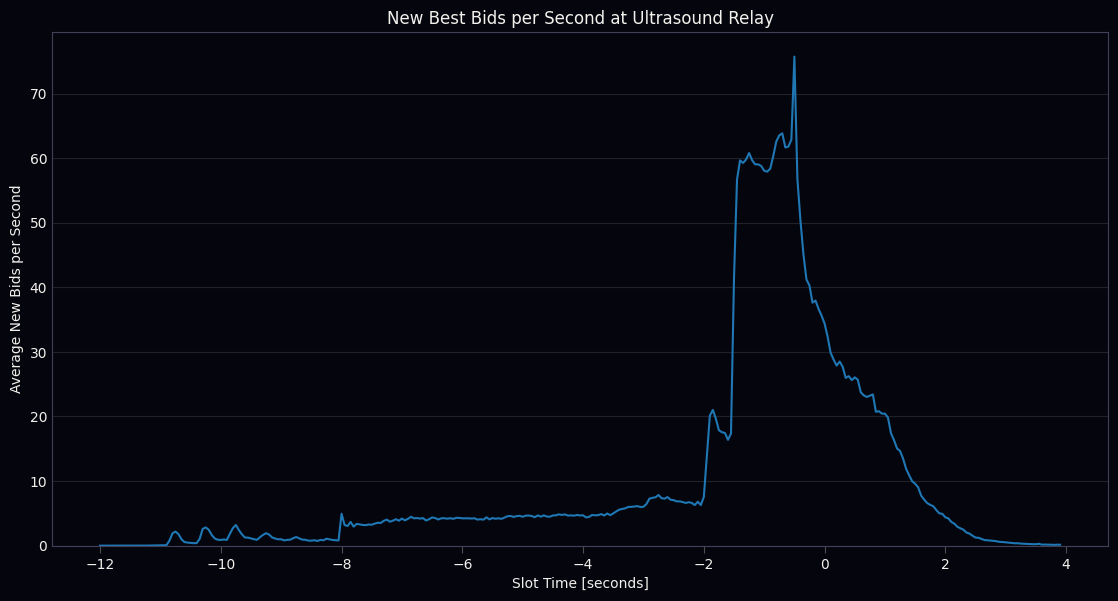

In [8]:
fig, ax = set_plt_defaults(figsize=(12.0, 6.5), left=0.07, right=0.95, bottom=0.10, top=0.89, grid_on=True)
plt.title('New Best Bids per Second at Ultrasound Relay')

binsize = 0.05  # bin size in seconds
websocket['cummax'] = websocket.groupby('slot')['value_eth'].cummax()
tmp = websocket[websocket['cummax'] == websocket['value_eth']]

count_slots = len(tmp['slot'].unique())
p_histogram = np.histogram(tmp['slot_time'], bins=np.arange(-12, 4, binsize), density=False)
ax.plot(p_histogram[1][:-1], p_histogram[0] / count_slots / binsize, label='2024H2')
plt.ylim(0, None)
plt.xlabel('Slot Time [seconds]')
plt.ylabel('Average New Bids per Second')
plt.show()


In [9]:
# Enrich the data with a builder pubkey map
# (https://datasets.flashbots.net/)

builder_map = pd.read_csv('mapping_pubkey_builder_name.csv')
websocket = pd.merge(
    left=websocket, 
    right=builder_map, 
    left_on='builder_pubkey', 
    right_on='pubkey', 
    how='left'
)

websocket['builder_name'].value_counts().head(5)

builder_name
beaverbuild.org    403864
Titan              292525
flashbots          157590
rsync               51087
penguinbuild        21942
Name: count, dtype: int64

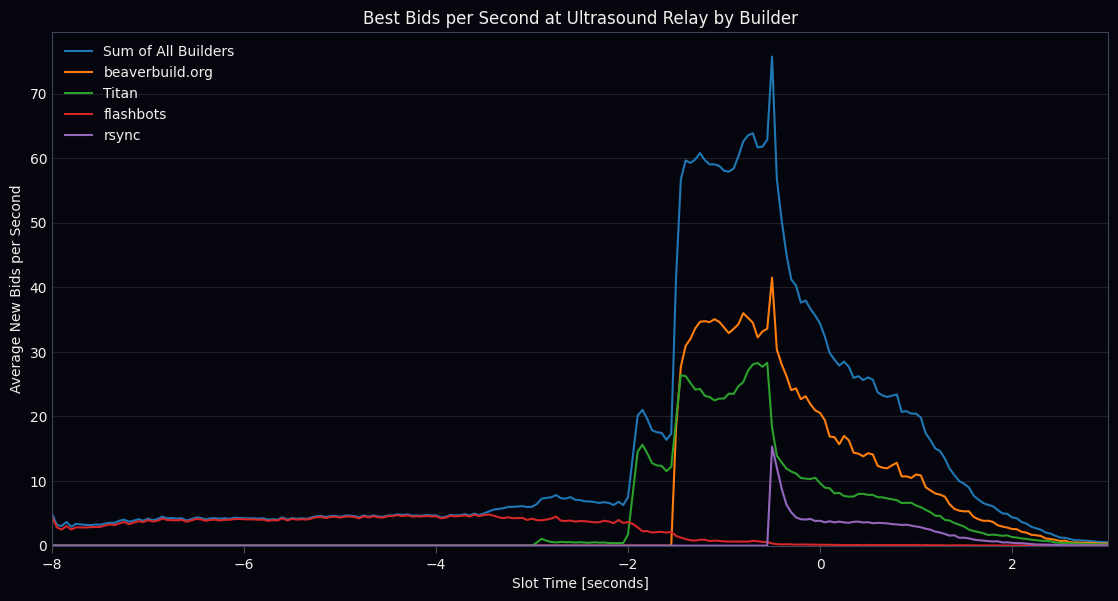

In [10]:
# Filter the best bids by a builder
fig, ax = set_plt_defaults(figsize=(12.0, 6.5), left=0.07, right=0.95, bottom=0.10, top=0.89, grid_on=True)
plt.title('Best Bids per Second at Ultrasound Relay by Builder')

websocket['cummax'] = websocket.groupby('slot')['value_eth'].cummax()
tmp = websocket[websocket['cummax'] == websocket['value_eth']]

count_slots = len(tmp['slot'].unique())
p_histogram = np.histogram(tmp['slot_time'], bins=np.arange(-12, 4, binsize), density=False)
ax.plot(p_histogram[1][:-1], p_histogram[0] / count_slots / binsize, label='Sum of All Builders')

# Iterate through each major builder
for xx in websocket['builder_name'].value_counts().head(4).index:
    subset = tmp[tmp['builder_name'] == xx]
    p_histogram = np.histogram(subset['slot_time'], bins=np.arange(-12, 4, binsize), density=False)
    ax.plot(p_histogram[1][:-1], p_histogram[0] / count_slots / binsize, label=xx)


plt.xlim(-8, 3)
plt.ylim(0, None)
plt.xlabel('Slot Time [seconds]')
plt.ylabel('Average New Bids per Second')
plt.legend(loc = 'upper left', frameon=False)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median: 19.0 ms


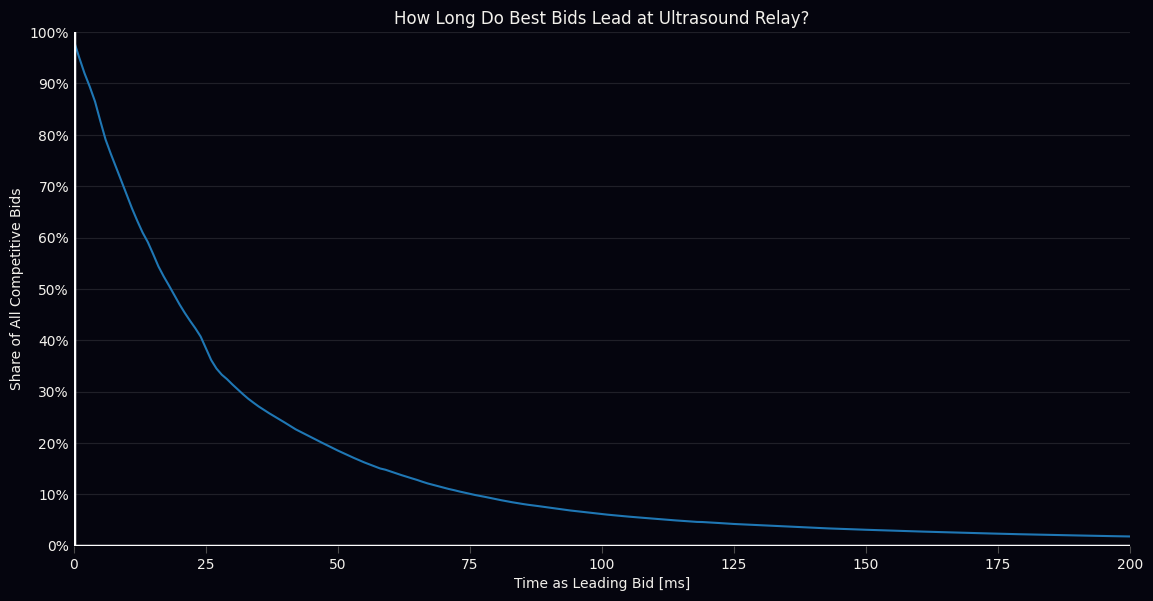

In [11]:
# Set plot defaults
fig, ax = set_plt_defaults(figsize=(12, 6.5), left=0.07, right=0.95, bottom=0.10, top=0.89, grid_on=True)
plt.title('How Long Do Best Bids Lead at Ultrasound Relay?')

# Filter for best bids
websocket['cummax'] = websocket.groupby('slot')['value_eth'].cummax()
tmp = websocket[websocket['cummax'] == websocket['value_eth']].copy()

# Compute lead time
tmp['lead_time'] = -tmp.groupby('slot')['slot_time'].diff(-1)

# Filter data within the interval of interest
t_min, t_max = 0, 1
tmp = tmp[(tmp['slot_time'] > t_min) & (tmp['slot_time'] < t_max)]

# Compute cumulative histogram
bins = np.arange(0, 2, 0.001)
p_lead_hist = np.histogram(tmp['lead_time'], bins=bins, density=False)
cdf = 1 - (np.cumsum(p_lead_hist[0]) / len(tmp['lead_time']))

# Plot lead time distribution
plt.plot(bins[:-1], cdf)

# Format plot
ax.set_yticks(np.arange(t_min, t_max + 0.01, 0.1))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xticks(np.arange(0, 0.51, 0.025))
ax.set_xticklabels([int(x * 1000) for x in ax.get_xticks()])
plt.ylim([0, 1])
plt.xlim([0, 0.200])
plt.xlabel('Time as Leading Bid [ms]')
plt.ylabel('Share of All Competitive Bids')
plt.legend(loc='upper right', facecolor='k', frameon=False)
ax.axhline(y=0, lw=2.5, color='w')
ax.axvline(x=0, lw=2.5, color='w')

# Print median lead time
print('Median:', round(tmp['lead_time'].median() * 1000, 2), 'ms')

# Final plot adjustments
plt.box(False)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median: 0.1038 %


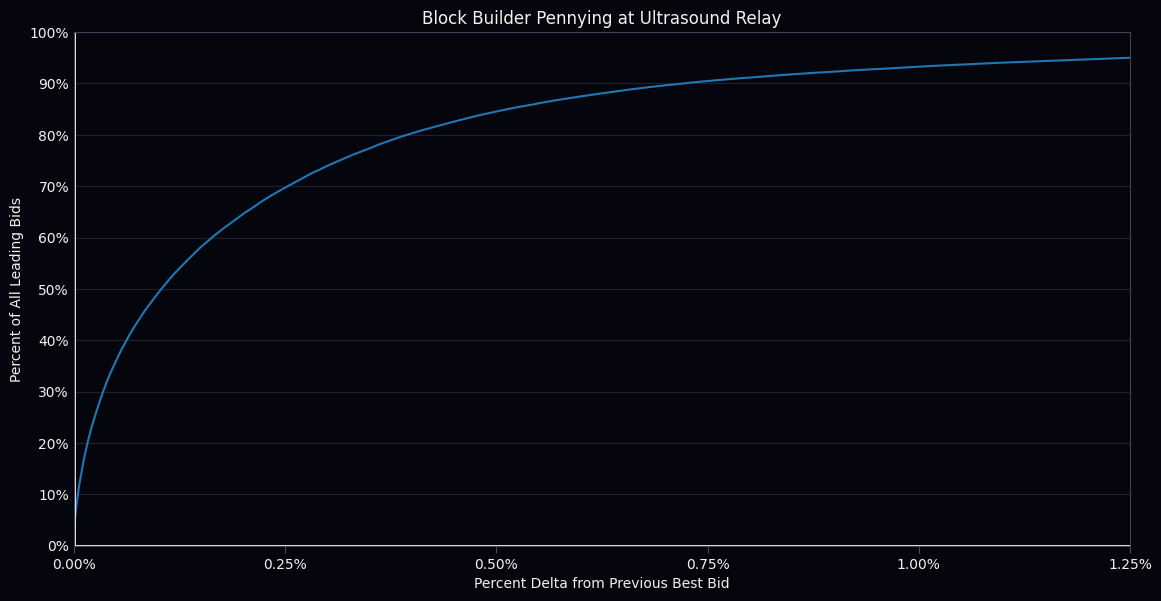

In [12]:
fig, ax = set_plt_defaults(figsize=(12.0, 6.5), left=0.07, right=0.95, bottom=0.10, top=0.89, grid_on=True)
plt.title('Block Builder Pennying at Ultrasound Relay')

websocket['cummax'] = websocket.groupby('slot')['value_eth'].cummax()
tmp = websocket[websocket['cummax'] == websocket['value_eth']]

# How much does a bid beat the previous best bid
tmp['penny'] = tmp.groupby('slot')['value_eth'].pct_change()

# Filter data within the interval of interest
t_min, t_max = 0, 1
tmp = tmp[(tmp['slot_time'] > t_min) & (tmp['slot_time'] < t_max)]

# Sanity check. Make sure bids are higher and aren't mega increases
tmp = tmp[tmp['penny'] > 0]
tmp = tmp[tmp['penny'] < 1]
    
# Plot the cumulative histogram 
p_penny_hist = np.histogram(tmp['penny'], bins=np.arange(0, 0.05, 0.000001), density=False)
plt.plot(p_penny_hist[1][0:-1], pd.DataFrame(p_penny_hist[0])[0].cumsum() / len(tmp['penny']))

# Format the plot
ax.set_xticks(np.arange(0, 0.051, 0.0025))
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_yticks(np.arange(0, 1.01, 0.1))
plt.ylim([0, 1])
plt.xlim([0, 0.0125])

plt.ylabel('Percent of All Leading Bids')
plt.xlabel('Percent Delta from Previous Best Bid')
plt.legend(loc='lower right', facecolor='k', frameon=False)
ax.axhline(y=0, color='w', lw=2)
ax.axvline(x=0, color='w', lw=2)
plt.legend(loc='lower right', frameon=False)

print('Median:', round(tmp['penny'].median() * 100, 4), '%')
plt.show()